In [164]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [165]:
# Membaca dataset yang telah digabungkan
file_path = 'C:/Users/dzak/Documents/SERTIFIKAT BANGKIT 24/projek capstone/arramooz-master/jamid_musytaq_vn2.csv'
df = pd.read_csv(file_path, encoding='utf-8')


In [166]:
df['text'] = df['unvocalized'].fillna('') + ' ' + df['vocalized'].fillna('')

# Fitur (X) dan label (y)
X = df['text']
y = df['jamid']  # Menggunakan kolom 'jamid' sebagai label (0 atau 1)


In [167]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan latih TfidfVectorizer pada data pelatihan
vectorizer = TfidfVectorizer(max_features=30000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Konversi ke TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tfidf.toarray(), y_train.values))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_tfidf.toarray(), y_val.values))

# Terapkan vectorizer pada dataset pelatihan dan validasi
train_dataset_vectorized = train_dataset.map(lambda x, y: (x, y))
validation_dataset_vectorized = validation_dataset.map(lambda x, y: (x, y))

# Tampilkan beberapa contoh dari dataset yang telah di-vectorisasi


In [168]:
for x, y in train_dataset_vectorized.take(1):
    print("Fitur:", x)
    print("Label:", y)

for x,y in validation_dataset_vectorized.take(1):
    print("Fitur:", x)
    print("Label:", y)
    
print(X_train_tfidf.shape)  # Should be (number_of_samples, 19000)
print(X_val_tfidf.shape)  

Fitur: tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(15076,), dtype=float64)
Label: tf.Tensor(1, shape=(), dtype=int64)
Fitur: tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(15076,), dtype=float64)
Label: tf.Tensor(1, shape=(), dtype=int64)
(23960, 15076)
(5990, 15076)


In [169]:
# GRADED FUNCTION: train_val_datasets

def train_val_datasets(dataset,validation_split=0.2, batch_size=32):
    """
    Splits the dataset into training and validation sets, after shuffling it.
    
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with elements as (sentence, label)
        validation_split (float): Fraction of the dataset to be used for validation
        batch_size (int): Number of samples per batch
    
    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    """   
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=len(dataset))
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(dataset) * (1 - validation_split))

    # Split the sentences and labels into train/validation splits
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Turn the dataset into a batched dataset with num_batches batches
    train_dataset = train_dataset.batch(batch_size)
    validation_dataset = validation_dataset.batch(batch_size)
    
    return train_dataset, validation_dataset


In [170]:
train_dataset_vectorized, validation_dataset_vectorized = train_val_datasets(train_dataset)

In [172]:
# Membangun model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(15076,)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 128)            │     1,929,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,938,945 (7.40 MB)

 Trainable params: 1,938,561 (7.40 MB)

 Non-trainable params: 384 (1.50 KB)

In [173]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Pelatihan model dengan early stopping dan reduce learning rate on plateau
history = model.fit(train_dataset_vectorized, epochs=30, validation_data=validation_dataset_vectorized, callbacks=[early_stopping, reduce_lr])

# Evaluasi model
loss, accuracy = model.evaluate(validation_dataset_vectorized)
print(f"Akurasi pada set pengujian: {accuracy}")


Epoch 1/30


599/599 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - accuracy: 0.6172 - loss: 0.6928 - val_accuracy: 0.8276 - val_loss: 0.4469 - learning_rate: 0.0010
Epoch 2/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.8209 - loss: 0.3946 - val_accuracy: 0.9487 - val_loss: 0.1752 - learning_rate: 0.0010
Epoch 3/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.9144 - loss: 0.2403 - val_accuracy: 0.9637 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 4/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 36s 56ms/step - accuracy: 0.9345 - loss: 0.1838 - val_accuracy: 0.9683 - val_loss: 0.0965 - learning_rate: 0.0010
Epoch 5/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 35s 54ms/step - accuracy: 0.9440 - loss: 0.1629 - val_accuracy: 0.9741 - val_loss: 0.0796 - learning_rate: 0.0010
Epoch 6/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9516 - loss: 0.1434 - val_accuracy: 0.9745 - val_loss: 0.0750 - learning_rate: 0.0010
Epoch 7/30
599/599 ━━━━━━━━━━━━━━━━━━━━ 34s 53ms/step - accuracy: 0.9555 - loss: 0.1333

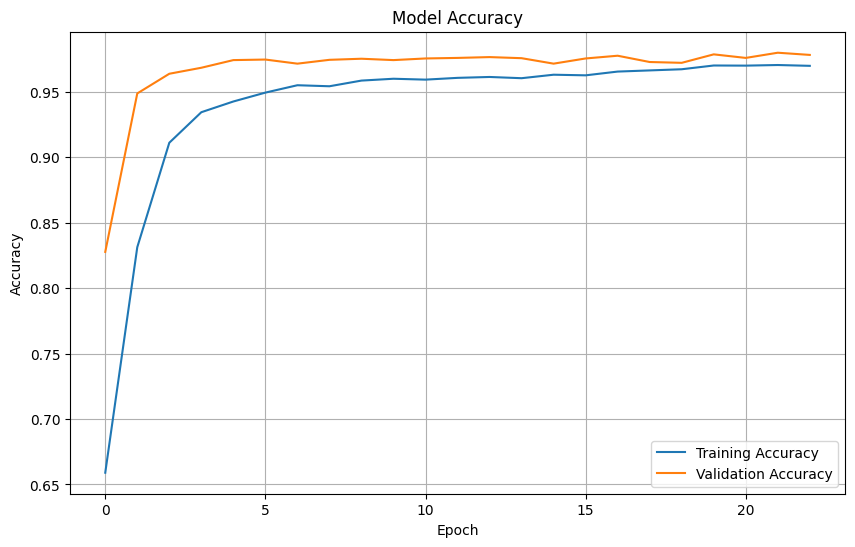

In [174]:
# Plot akurasi
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [190]:

# Kata baru yang ingin diuji
new_word = "روي"

# Preprocessing kata baru
new_word_tfidf = vectorizer.transform([new_word])

# Prediksi dengan model
prediction = model.predict(new_word_tfidf.toarray())

# Menampilkan hasil prediksi
label = 'jamid' if prediction[0] >= 0.5 else 'musytaq'
print(f"Kata '{new_word}' dikenali sebagai: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Kata 'روي' dikenali sebagai: musytaq
